In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy import sparse
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.cross_validation import train_test_split
import nltk.data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
%matplotlib inline
from xgboost import plot_importance

In [2]:
BASE_URL = '/Users/denissamohvalov/Documents/minor-project'

In [8]:
df_train = pd.read_csv(BASE_URL + '/train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
df_test = pd.read_csv(BASE_URL + '/test.csv')
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


# Синтаксический анализ

Количество пар в обучающей выборке: 404290
Количество пар в тестовой выборке: 2345796
Отношение обучающей к тестовой: 5.802260753419575
Количество одинаковых пар в обучающей выборке: 149263
Доля одинаковых пар в обучающей выборке: 0.369197853026293
Количество уникальных вопросов в обучающей выборке: 537933
Доля уникальных вопросов в обучающей выборке: 0.6652811100942393
Количество вопросов, которые встречаются в обучающей выбор больше 1 раза: 111780
Доля вопросов, которые встречаются в обучающей выборке больше 1 раза: 0.13824235078780084


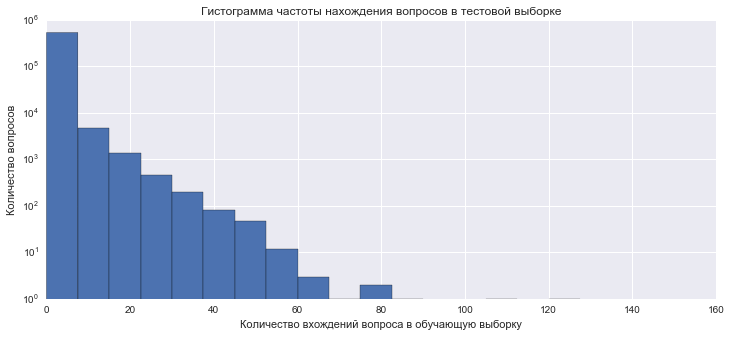

In [43]:
n_train = len(df_train)
n_test = len(df_test)
n_dupl_train = len(df_train[df_train['is_duplicate'] == 1])
print('Количество пар в обучающей выборке: %s' % n_train)
print('Количество пар в тестовой выборке: %s' % n_test)
print('Отношение обучающей к тестовой: %s' % (n_test / n_train))
print('Количество одинаковых пар в обучающей выборке: %s' % n_dupl_train)
print('Доля одинаковых пар в обучающей выборке: %s' % (n_dupl_train / n_train))
q1_train = df_train['qid1'].tolist()
q2_train = df_train['qid2'].tolist()
total_train = pd.Series(q1_train + q2_train)
train_unique = np.unique(total_train)
n_train_unique = len(train_unique)
n_total_train = len(total_train)
n_more_than_one = np.sum(total_train.value_counts() > 1)
print('Количество уникальных вопросов в обучающей выборке: %s' % n_train_unique)
print('Доля уникальных вопросов в обучающей выборке: %s' % (n_train_unique / n_total_train))
print('Количество вопросов, которые встречаются в обучающей выбор больше 1 раза: {0}'.format(n_more_than_one))
print('Доля вопросов, которые встречаются в обучающей выборке больше 1 раза: {0}'.format(n_more_than_one / n_total_train))
plt.figure(figsize=(12, 5))
plt.hist(total_train.value_counts(), bins=20, range=[0,150])
plt.yscale('log')
plt.title('Гистограмма частоты нахождения вопросов в тестовой выборке')
plt.xlabel('Количество вхождений вопроса в обучающую выборку')
plt.ylabel('Количество вопросов')


In [44]:
# больше 15 -  1000,
# есть вопросы, которые встречаются больше 100 раз

In [47]:
print("Максимально встречающийся вопрос, встречается в датасете %s раз" % total_train.value_counts().max())

Максимально встречающийся вопрос встречается в датасете 157 раз


/Users/denissamohvalov/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Среднее количество символов в вопросе: 59.82254817086745
Минимальное число символов в вопросе: 1
Максимальное число символов в вопросе: 1169
Стандартное отклонение числа символов в вопросе: 31.963751494576986


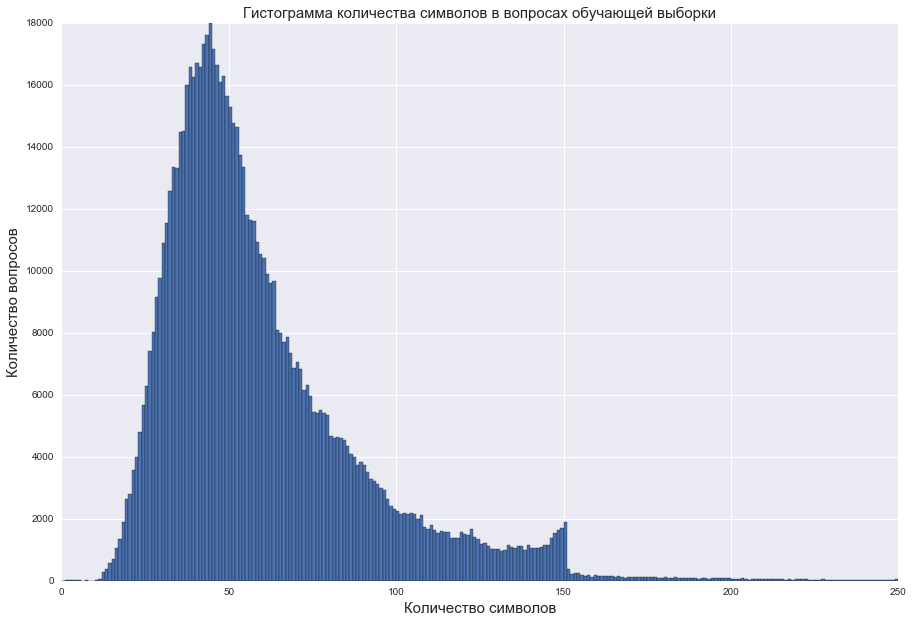

In [70]:
# Обучающая выборка
question1_train = df_train['question1'].tolist()
question2_train = df_train['question2'].tolist()
train_qs = pd.Series(question1_train + question2_train).astype(str)

dist_train = train_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=250, range=[0, 250])
plt.title('Гистограмма количества символов в вопросах обучающей выборки', fontsize=15)
plt.legend()
plt.xlabel('Количество символов', fontsize=15)
plt.ylabel('Количество вопросов', fontsize=15)
print('Среднее количество символов в вопросе: %s' % dist_train.mean())
print('Минимальное число символов в вопросе: %s' % dist_train.min())
print('Максимальное число символов в вопросе: %s' % dist_train.max())
print('Стандартное отклонение числа символов в вопросе: %s' % dist_train.std())

/Users/denissamohvalov/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Среднее количество символов в вопросе: 60.070103282638385
Минимальное число символов в вопросе: 1
Максимальное число символов в вопросе: 1176
Стандартное отклонение числа символов в вопросе: 31.624631019887765


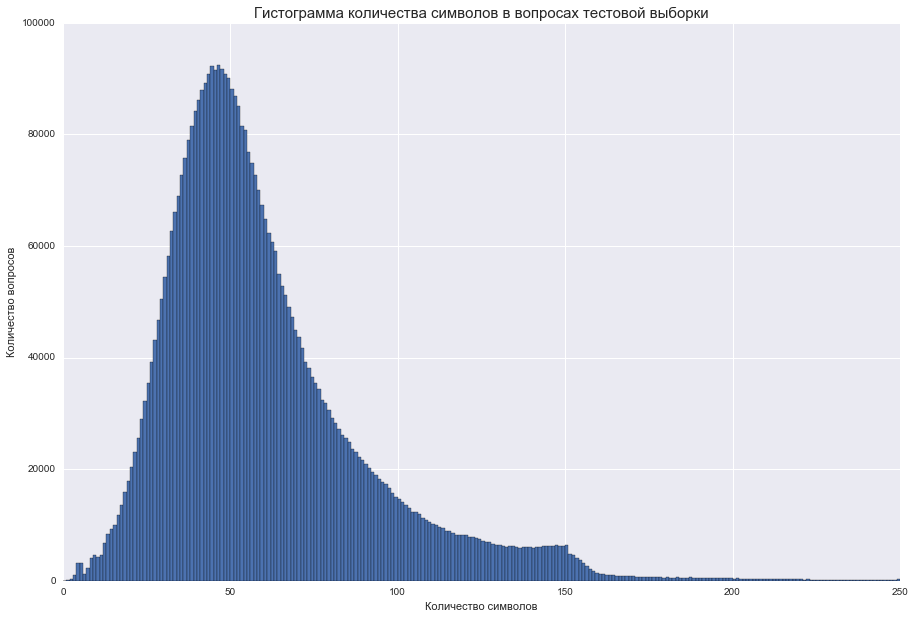

In [71]:
question1_test = df_test['question1'].tolist()
question2_test = df_test['question2'].tolist()
train_qs = pd.Series(question1_test + question2_test).astype(str)

dist_train = train_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=250, range=[0, 250])
plt.title('Гистограмма количества символов в вопросах тестовой выборки', fontsize=15)
plt.legend()
plt.xlabel('Количество символов')
plt.ylabel('Количество вопросов')
print('Среднее количество символов в вопросе: %s' % dist_train.mean())
print('Минимальное число символов в вопросе: %s' % dist_train.min())
print('Максимальное число символов в вопросе: %s' % dist_train.max())
print('Стандартное отклонение числа символов в вопросе: %s' % dist_train.std())

In [72]:
# В тестовой выборке намеренно внедрены искусственно сгенерированные вопросы
# Видимо поэтому распределение выглядит более плавно, чем в обучающе выборке

/Users/denissamohvalov/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Среднее количество слов в вопросе: 11.062100225085953
Минимальное число слов в вопросе: 1
Максимальное число слов в вопросе: 237
Стандартное отклонение числа слов в вопросе: 5.884594849343418


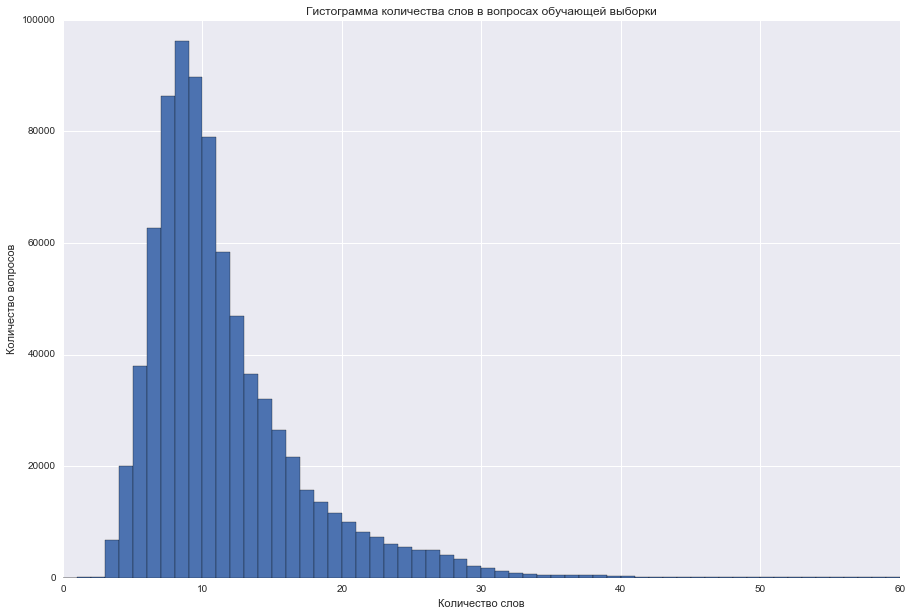

In [73]:
# Обучающая выборка
train_qs = pd.Series(question1_train + question2_train).astype(str)
dist_train = train_qs.apply(lambda x: x.split()).apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=60, range=[0, 60])
plt.title('Гистограмма количества слов в вопросах обучающей выборки')
plt.legend()
plt.xlabel('Количество слов')
plt.ylabel('Количество вопросов')
print('Среднее количество слов в вопросе: %s' % dist_train.mean())
print('Минимальное число слов в вопросе: %s' % dist_train.min())
print('Максимальное число слов в вопросе: %s' % dist_train.max())
print('Стандартное отклонение числа слов в вопросе: %s' % dist_train.std())

/Users/denissamohvalov/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Среднее количество слов в вопросе: 11.01826650740303
Минимальное число слов в вопросе: 1
Максимальное число слов в вопросе: 238
Стандартное отклонение числа слов в вопросе: 5.846748191364327


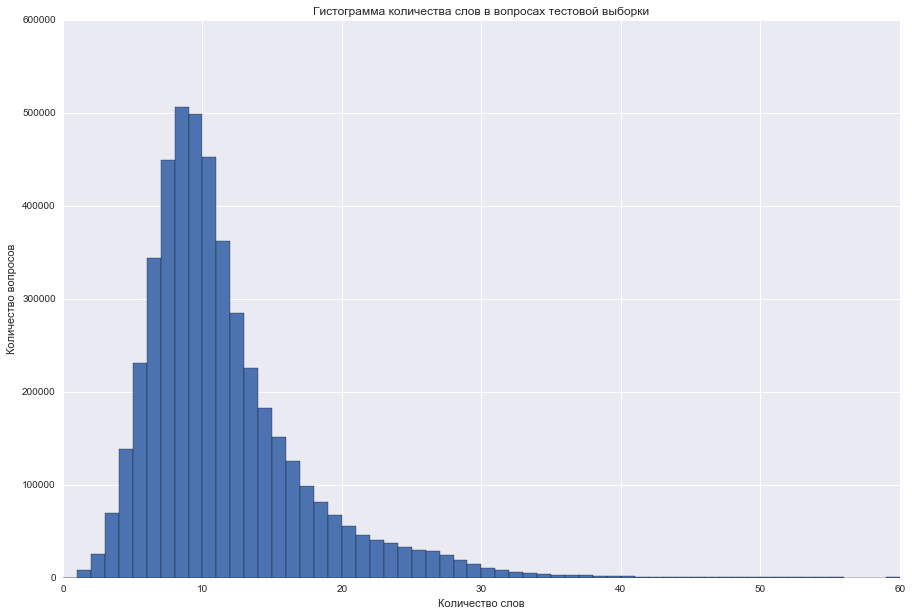

In [69]:
# Тестовая выборка
train_qs = pd.Series(question1_test + question2_test).astype(str)

dist_train = test_qs.apply(lambda x: x.split()).apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=60, range=[0, 60])
plt.title('Гистограмма количества слов в вопросах тестовой выборки')
plt.legend()
plt.xlabel('Количество слов')
plt.ylabel('Количество вопросов')
print('Среднее количество слов в вопросе: %s' % dist_train.mean())
print('Минимальное число слов в вопросе: %s' % dist_train.min())
print('Максимальное число слов в вопросе: %s' % dist_train.max())
print('Стандартное отклонение числа слов в вопросе: %s' % dist_train.std())

In [74]:
# Максимальное количество слов - 238, видимо, это ограничение непосредственно в quora 

/Users/denissamohvalov/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Среднее количество предложений в вопросе: 1.1171188997996488
Минимальное число предложений в вопросе: 1
Максимальное число предложений в вопросе: 22
Стандартное отклонение предложений слов в вопросе: 0.40650825537126567


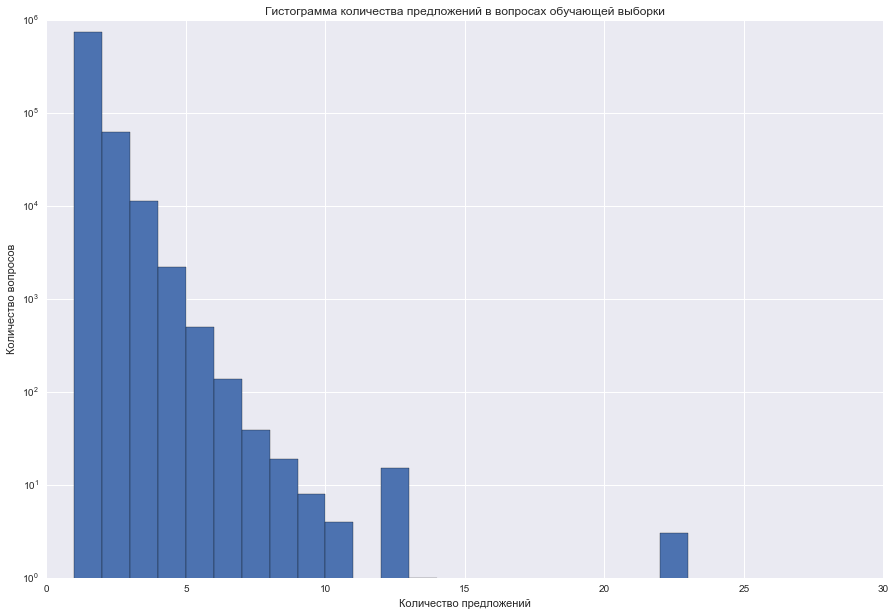

In [104]:
# Обучающая выборка
train_qs = pd.Series(question1_train + question2_train).astype(str)

dist_train = train_qs.apply(tokenizer.tokenize).apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=30, range=[0, 30])
plt.title('Гистограмма количества предложений в вопросах обучающей выборки')
plt.yscale('log')
plt.legend()
plt.xlabel('Количество предложений')
plt.ylabel('Количество вопросов')
print('Среднее количество предложений в вопросе: %s' % dist_train.mean())
print('Минимальное число предложений в вопросе: %s' % dist_train.min())
print('Максимальное число предложений в вопросе: %s' % dist_train.max())
print('Стандартное отклонение предложений в вопросе: %s' % dist_train.std())

/Users/denissamohvalov/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Среднее количество предложений в вопросе: 1.123127074988618
Минимальное число предложений в вопросе: 1
Максимальное число предложений в вопросе: 22
Стандартное отклонение предложений слов в вопросе: 0.4150551854570918


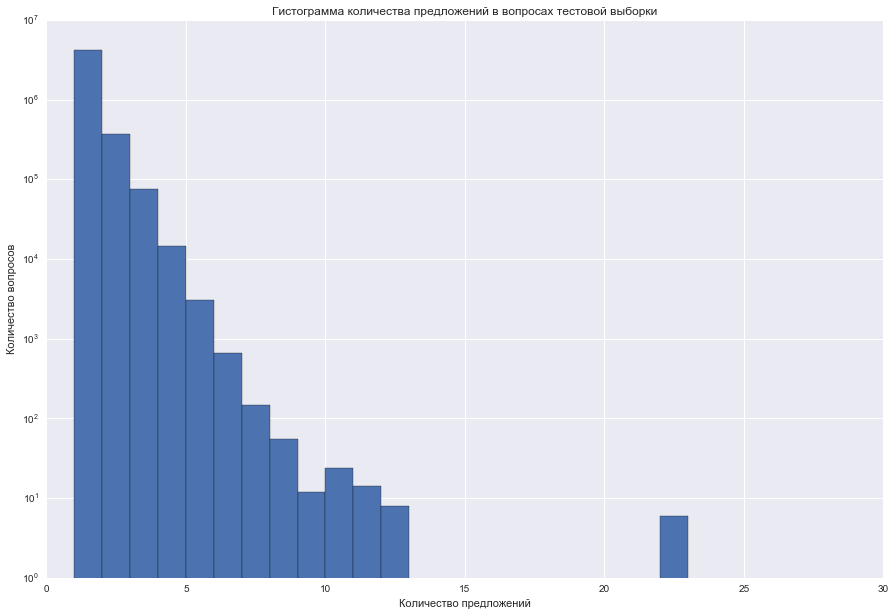

In [105]:
# Тестовая выборка
train_qs = pd.Series(question1_test + question2_test).astype(str)
dist_train = train_qs.apply(tokenizer.tokenize).apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=30, range=[0, 30])
plt.title('Гистограмма количества предложений в вопросах тестовой выборки')
plt.yscale('log')
plt.legend()
plt.xlabel('Количество предложений')
plt.ylabel('Количество вопросов')
print('Среднее количество предложений в вопросе: %s' % dist_train.mean())
print('Минимальное число предложений в вопросе: %s' % dist_train.min())
print('Максимальное число предложений в вопросе: %s' % dist_train.max())
print('Стандартное отклонение предложений  в вопросе: %s' % dist_train.std())

In [24]:
duplicate = df_train[df_train['is_duplicate'] == 1]
q1_duplicate = duplicate['question1'].tolist()
q2_duplicate = duplicate['question2'].tolist()

/Users/denissamohvalov/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Среднее разницы длин одинаковых вопросов: 13.142654241171623
Минимальная разница в длине вопросов: 0.0
Максимальное разница в длине вопросов: 196.0
Стандартное отклонение длин вопросов: 14.382099735513112


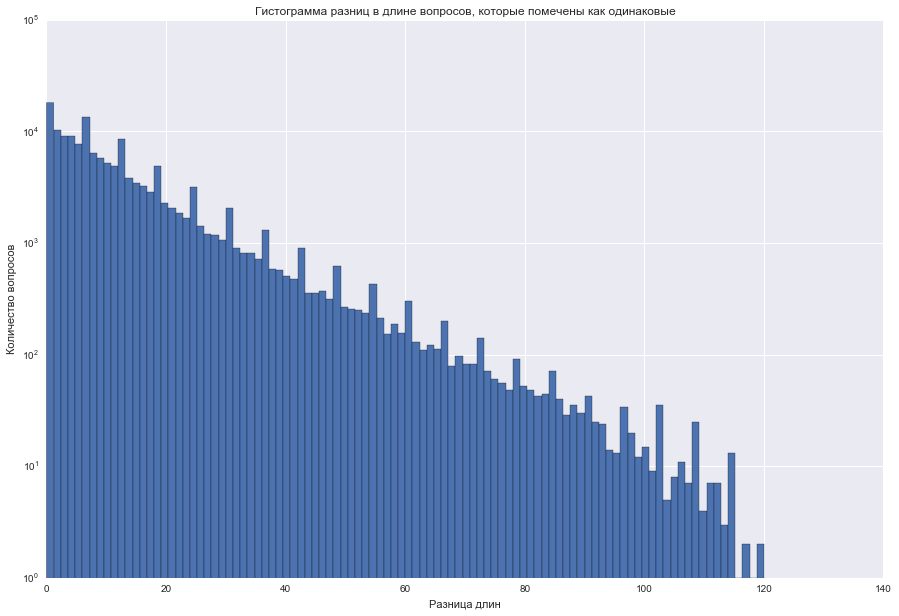

In [31]:
# Обучающая выборка
q1_len = pd.Series(q1_duplicate).astype(str).apply(len)
q2_len = pd.Series(q2_duplicate).astype(str).apply(len)
dist_train = pd.Series(np.abs(q1_len - q2_len)).astype(float)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=100, range=[0, 120])
plt.title('Гистограмма разниц в длине вопросов, которые помечены как одинаковые')
plt.yscale('log')
plt.legend()
plt.xlabel('Разница длин')
plt.ylabel('Количество вопросов')
print('Среднее разницы длин одинаковых вопросов: %s' % dist_train.mean())
print('Минимальная разница в длине вопросов: %s' % dist_train.min())
print('Максимальное разница в длине вопросов: %s' % dist_train.max())
print('Стандартное отклонение длин вопросов: %s' % dist_train.std())

In [32]:
nonduplicate = df_train[df_train['is_duplicate'] == 0]
q1_nonduplicate = nonduplicate['question1'].tolist()
q2_nonduplicate = nonduplicate['question2'].tolist()

/Users/denissamohvalov/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Среднее разницы длин одинаковых вопросов: 24.26424653075949
Минимальная разница в длине вопросов: 0.0
Максимальное разница в длине вопросов: 1080.0
Стандартное отклонение длин вопросов: 29.511663764664586


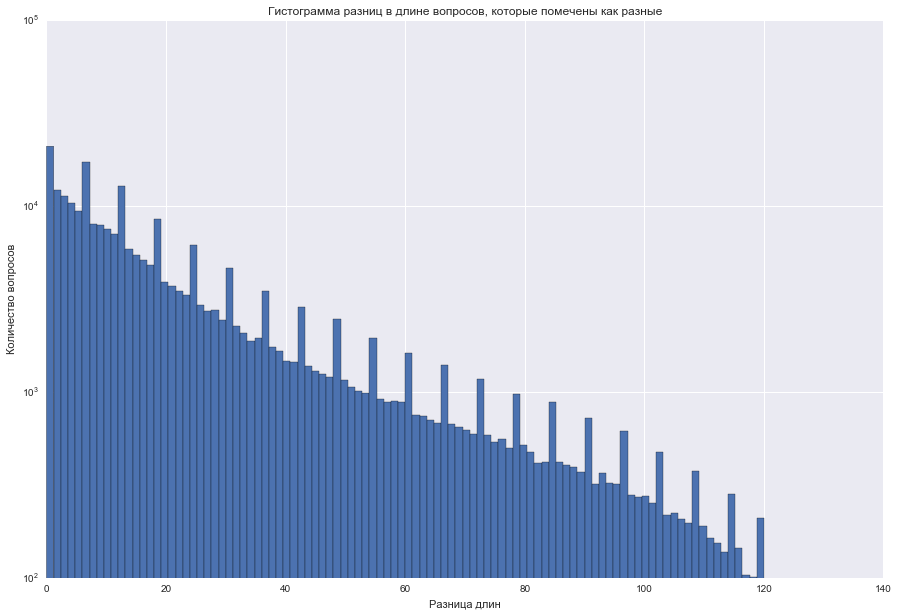

In [33]:
# Обучающая выборка
q1_len = pd.Series(q1_nonduplicate).astype(str).apply(len)
q2_len = pd.Series(q2_nonduplicate).astype(str).apply(len)
dist_train = pd.Series(np.abs(q1_len - q2_len)).astype(float)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=100, range=[0, 120])
plt.title('Гистограмма разниц в длине вопросов, которые помечены как разные')
plt.yscale('log')
plt.legend()
plt.xlabel('Разница длин')
plt.ylabel('Количество вопросов')
print('Среднее разницы длин одинаковых вопросов: %s' % dist_train.mean())
print('Минимальная разница в длине вопросов: %s' % dist_train.min())
print('Максимальное разница в длине вопросов: %s' % dist_train.max())
print('Стандартное отклонение длин вопросов: %s' % dist_train.std())

/Users/denissamohvalov/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Среднее разницы количества слов одинаковых вопросов: 2.420981757032888
Минимальная разница количества слов в одинаковых вопросах: 0.0
Максимальная разница количества слов в одинаковых вопросах: 39.0
Стандартное отклонение количества слов в одинаковых вопросах: 2.6871555261924955


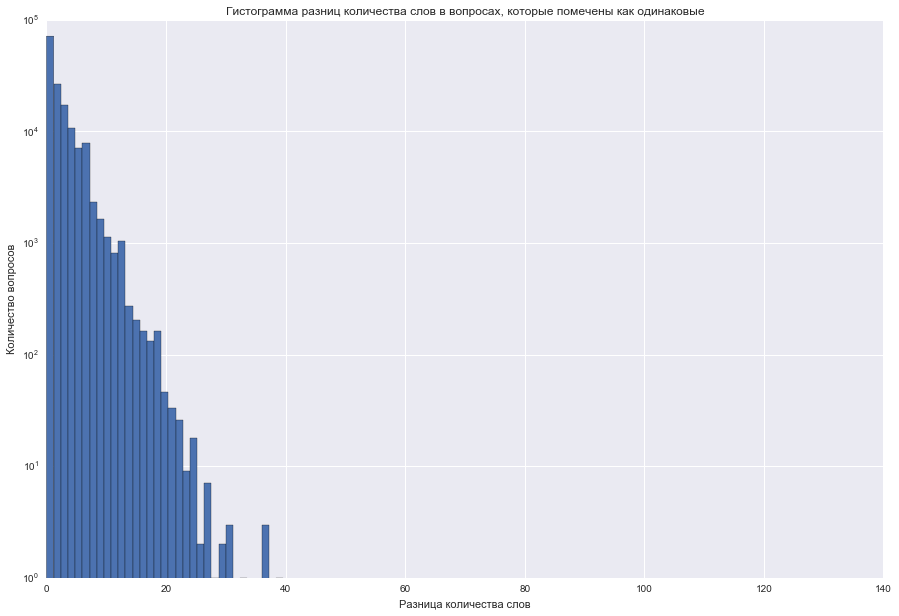

In [34]:
# Обучающая выборка
q1_len = pd.Series(q1_duplicate).astype(str).apply(lambda x: len(x.split()))
q2_len = pd.Series(q2_duplicate).astype(str).apply(lambda x: len(x.split()))
dist_train = pd.Series(np.abs(q1_len - q2_len)).astype(float)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=100, range=[0, 120])
plt.title('Гистограмма разниц количества слов в вопросах, которые помечены как одинаковые')
plt.yscale('log')
plt.legend()
plt.xlabel('Разница количества слов')
plt.ylabel('Количество вопросов')
print('Среднее разницы количества слов одинаковых вопросов: %s' % dist_train.mean())
print('Минимальная разница количества слов в одинаковых вопросах: %s' % dist_train.min())
print('Максимальная разница количества слов в одинаковых вопросах: %s' % dist_train.max())
print('Стандартное отклонение количества слов в одинаковых вопросах: %s' % dist_train.std())

/Users/denissamohvalov/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Среднее разницы количества слов одинаковых вопросов: 4.439435824442118
Минимальная разница количества слов в одинаковых вопросах: 0.0
Максимальная разница количества слов в одинаковых вопросах: 223.0
Стандартное отклонение количества слов в одинаковых вопросах: 5.595228126205865


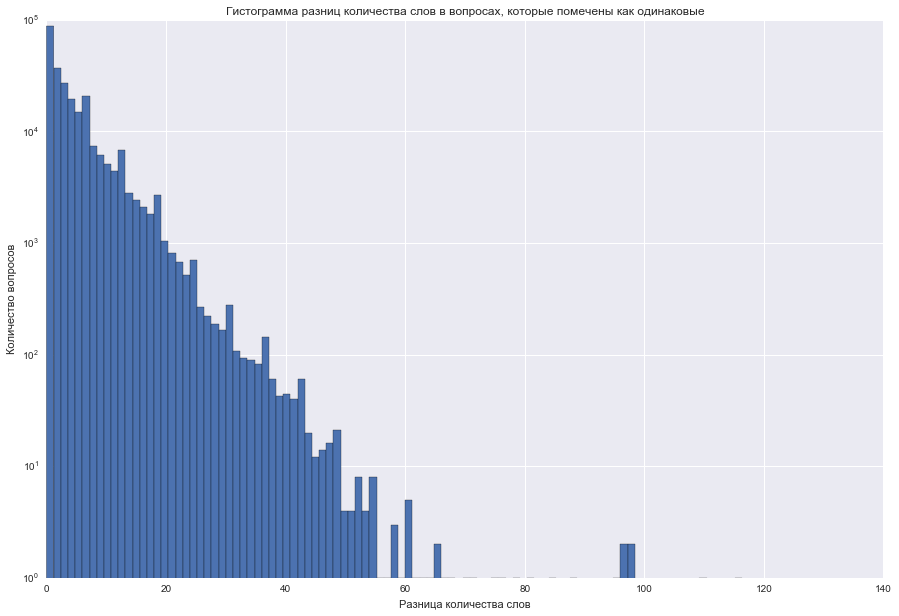

In [35]:
# Обучающая выборка
q1_len = pd.Series(q1_nonduplicate).astype(str).apply(lambda x: len(x.split()))
q2_len = pd.Series(q2_nonduplicate).astype(str).apply(lambda x: len(x.split()))
dist_train = pd.Series(np.abs(q1_len - q2_len)).astype(float)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=100, range=[0, 120])
plt.title('Гистограмма разниц количества слов в вопросах, которые помечены как разные')
plt.yscale('log')
plt.legend()
plt.xlabel('Разница количества слов')
plt.ylabel('Количество вопросов')
print('Среднее разницы количества слов разных вопросов: %s' % dist_train.mean())
print('Минимальная разница количества слов в разных вопросах: %s' % dist_train.min())
print('Максимальная разница количества слов в разных вопросах: %s' % dist_train.max())
print('Стандартное отклонение количества слов в разных вопросах: %s' % dist_train.std())

# Cемантический анализ

In [87]:
# Обучающаяя выборка
import string
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x or '!' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
digits = np.mean(train_qs.apply(lambda x: max([j in '0123456789' for i in x for j in i ])))
question_words = ['what', 'when', 'why', 'which', 'who', 'how', 'whose', 'whom']
q_words = np.mean(train_qs.apply(lambda x: x.split()[0].lower() in question_words))
asc = np.mean(train_qs.apply(lambda x: max([j not in string.printable for i in x  for j in i])))
print('Доля вопросов со знаком вопроса: %s' % qmarks)
print('Доля вопросов с математическими символами: %s' % math)
print('Доля вопросов с точкой или воскл. знаком в конце: %s' % fullstop)
print('Доля вопросов с первыми заглавными буквами: %s' % capital_first)
print('Доля вопросов с заглвными буквами: %s' % capitals)
print('Доля вопросов со знаками вопроса: %s' % q_words)
print('Доля вопросов с символами, которые не в ascii: %s' % asc)
print('Доля вопросов с цифрами: %s' % digits)

Доля вопросов со знаком вопроса: 0.998738529274
Доля вопросов с математическими символами: 0.00117366247001
Доля вопросов с точкой или воскл. знаком в конце: 0.0639924311756
Доля вопросов с первыми заглавными буквами: 0.99813252863
Доля вопросов с заглвными буквами: 0.999505305597
Доля вопросов со знаками вопроса: 0.719065522274
Доля вопросов с символами, которые не в ascii: 0.0118998738529
Доля вопросов с цифрами: 0.118260407133


In [88]:
# Тестовая выборка
import string
qmarks = np.mean(test_qs.apply(lambda x: '?' in x))
math = np.mean(test_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(test_qs.apply(lambda x: '.' in x or '!' in x))
capital_first = np.mean(test_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(test_qs.apply(lambda x: max([y.isupper() for y in x])))
digits = np.mean(test_qs.apply(lambda x: max([j in '0123456789' for i in x for j in i ])))
question_words = ['what', 'when', 'why', 'which', 'who', 'how', 'whose', 'whom']
q_words = np.mean(test_qs.apply(lambda x: x.split()[0].lower() in question_words))
asc = np.mean(test_qs.apply(lambda x: max([j not in string.printable for i in x  for j in i])))
print('Доля вопросов со знаком вопроса: %s' % qmarks)
print('Доля вопросов с математическими символами: %s' % math)
print('Доля вопросов с точкой или воскл. знаком в конце: %s' % fullstop)
print('Доля вопросов с первыми заглавными буквами: %s' % capital_first)
print('Доля вопросов с заглвными буквами: %s' % capitals)
print('Доля вопросов со знаками вопроса: %s' % q_words)
print('Доля вопросов с символами, которые не в ascii: %s' % asc)
print('Доля вопросов с цифрами: %s' % digits)

Доля вопросов со знаком вопроса: 0.993881820926
Доля вопросов с математическими символами: 0.0016972916656
Доля вопросов с точкой или воскл. знаком в конце: 0.0698426035342
Доля вопросов с первыми заглавными буквами: 0.997798401907
Доля вопросов с заглвными буквами: 0.99939380918
Доля вопросов со знаками вопроса: 0.703182203397
Доля вопросов с символами, которые не в ascii: 0.0110553091573
Доля вопросов с цифрами: 0.126624608448


Видно, что средняя разница и стандартное отклонение количества слов и букв среди пар вопросов, которые помечены как разные, значительно выше, чем разница слов и букв, которые помечены как разные. Поробуем обучить модель на этих признаках, плюс ко всем добавим еще несколько  новых признаков - отношение количества слов и букв, a так же  отношение и разность количества предложений.

In [4]:
def extract_features(data, df):
    q1_len = pd.Series(data['question1']).astype(str).apply(len)
    q2_len = pd.Series(data['question2']).astype(str).apply(len)
    df['abs_symb_dist'] = pd.Series(np.abs(q1_len - q2_len)).astype(float)

    q1_len = pd.Series(data['question1']).astype(str).apply(lambda x: len(x) if len(x) > 0 else 1.0)
    q2_len = pd.Series(data['question2']).astype(str).apply(lambda x: len(x) if len(x) > 0 else 1.0)
    dist = []
    for i, e in enumerate(q1_len):
        if q1_len[i] > q2_len[i]:
            dist.append(q2_len[i] / q1_len[i])
        else:
            dist.append(q1_len[i] / q2_len[i])
    df['symb_ratio'] = pd.Series(dist).astype(float)

    q1_len = pd.Series(data['question1']).astype(str).apply(lambda x: len(x.split()) if len(x.split()) > 0 else 1.0)
    q2_len = pd.Series(data['question2']).astype(str).apply(lambda x: len(x.split()) if len(x.split()) > 0 else 1.0)
    df['abs_word_dist'] = pd.Series(np.abs(q1_len - q2_len)).astype(float)

    q1_len = pd.Series(data['question1']).astype(str).apply(lambda x: len(x.split()) if len(x.split()) > 0 else 1.0)
    q2_len = pd.Series(data['question2']).astype(str).apply(lambda x: len(x.split()) if len(x.split()) > 0 else 1.0)
    dist = []
    for i, e in enumerate(q1_len):
        if q1_len[i] > q2_len[i]:
            dist.append(q2_len[i] / q1_len[i])
        else:
            dist.append(q1_len[i] / q2_len[i])
    df['word_ratio'] = pd.Series(dist).astype(float)

    q1_len = pd.Series(data['question1']).astype(str).apply(tokenizer.tokenize).apply(len)
    q2_len = pd.Series(data['question2']).astype(str).apply(tokenizer.tokenize).apply(len)
    df['sentences_dist'] = pd.Series(np.abs(q1_len - q2_len)).astype(float)

    q1_len = pd.Series(data['question1']).astype(str).apply(tokenizer.tokenize).apply(lambda x: len(x) if len(x) > 0 else 1)
    q2_len = pd.Series(data['question2']).astype(str).apply(tokenizer.tokenize).apply(lambda x: len(x) if len(x) > 0 else 1)
    dist = []
    for i, e in enumerate(q1_len):
        if q1_len[i] > q2_len[i]:
            dist.append(q2_len[i] / q1_len[i])
        else:
            dist.append(q1_len[i] / q2_len[i])
    df['sentences_ratio'] = pd.Series(dist).astype(float)
    return df


In [135]:
X_train = extract_features(df_train, pd.DataFrame())

In [17]:
y_train = df_train['is_duplicate']

In [18]:
import xgboost as xgb

def get_xgboost(X, y):
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'logloss'
    params['eta'] = 0.02
    params['max_depth'] = 4
    d_train = xgb.DMatrix(X, label=y)
    return xgb.train(params, d_train, num_round=300, early_stopping_rounds=50, verbose_eval=10)
  

In [140]:
model = get_xgboost(X_train, y_train)

[0]	train-logloss:0.690501	valid-logloss:0.690501
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.66897	valid-logloss:0.66897
[20]	train-logloss:0.653964	valid-logloss:0.653964
[30]	train-logloss:0.643405	valid-logloss:0.643405
[40]	train-logloss:0.635926	valid-logloss:0.635926
[50]	train-logloss:0.630409	valid-logloss:0.630409
[60]	train-logloss:0.626218	valid-logloss:0.626218
[70]	train-logloss:0.623106	valid-logloss:0.623106
[80]	train-logloss:0.620567	valid-logloss:0.620567
[90]	train-logloss:0.618679	valid-logloss:0.618679
[100]	train-logloss:0.617185	valid-logloss:0.617185
[110]	train-logloss:0.616029	valid-logloss:0.616029
[120]	train-logloss:0.614892	valid-logloss:0.614892
[130]	train-logloss:0.614042	valid-logloss:0.614042
[140]	train-logloss:0.613207	valid-logloss:0.613207
[150]	train-logloss:0.612535	valid-logloss:0.612535
[160]	train-logloss:0.611961	v

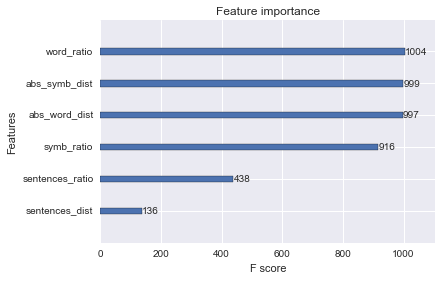

In [141]:
plot_importance(model)

In [142]:
X_test = extract_features(df_test, pd.DataFrame())

In [57]:
y_pred = model.predict(xgb.DMatrix(X_test))

In [26]:
def output(y, filename):
    sub = pd.DataFrame()
    sub['test_id'] = df_test['test_id']
    sub['is_duplicate'] = y
    sub.to_csv(filename, index=False)

In [59]:
output(y, 'first.csv')

0.52 - Скор на кэгле

In [60]:
def get_r_forest(X, y):
    r_forest = RandomForestClassifier(
        n_estimators = 100, 
        oob_score = True, 
        n_jobs = -1,
        random_state =50, 
        max_features = "auto", 
        min_samples_leaf = 50
    )
    r_forest.fit(X, y)
    return r_forest

In [36]:
r_forest = get_r_forest(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=50,
            verbose=0, warm_start=False)

In [37]:
y = r_forest.predict(X_test)

In [41]:
output(y, 'first_forest.csv')

In [ ]:
Скор на кэгле - 0.8

In [143]:
#Попробуем почистить данные
def clean(text):

    text = " ".join(text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"where's", "where is ", text)
    text = re.sub(r"why's", "why is ", text)
    text = re.sub(r"who's", "who is ", text)
    text = re.sub(r"when's", "when is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)

    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    
    return(text)

In [2]:
if os.path.isfile('cleaned_test.csv') and os.path.isfile('cleaned_train.csv'):
    df_test = pd.read_csv('cleaned_test.csv').fillna(" ")
    df_train = pd.read_csv('cleaned_train.csv').fillna(" ")
else:
    df_train['question1'] = df_train['question1'].apply(clean)
    df_train['question2'] = df_train['question2'].apply(clean)
    df_test['question1'] = df_test['question1'].apply(clean)
    df_test['question2'] = df_test['question2'].apply(clean)
    df_train.to_csv('cleaned_train.csv', index=False)
    df_test.to_csv('cleaned_test.csv', index=False)

In [145]:
X_train = extract_features(df_train, pd.DataFrame())

In [146]:
y_train = df_train['is_duplicate']
model = get_xgboost(X_train, y_train)

[0]	train-logloss:0.690501	valid-logloss:0.690501
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.66897	valid-logloss:0.66897
[20]	train-logloss:0.653964	valid-logloss:0.653964
[30]	train-logloss:0.643405	valid-logloss:0.643405
[40]	train-logloss:0.635926	valid-logloss:0.635926
[50]	train-logloss:0.630409	valid-logloss:0.630409
[60]	train-logloss:0.626218	valid-logloss:0.626218
[70]	train-logloss:0.623106	valid-logloss:0.623106
[80]	train-logloss:0.620567	valid-logloss:0.620567
[90]	train-logloss:0.618679	valid-logloss:0.618679
[100]	train-logloss:0.617185	valid-logloss:0.617185
[110]	train-logloss:0.616029	valid-logloss:0.616029
[120]	train-logloss:0.614892	valid-logloss:0.614892
[130]	train-logloss:0.614042	valid-logloss:0.614042
[140]	train-logloss:0.613207	valid-logloss:0.613207
[150]	train-logloss:0.612535	valid-logloss:0.612535
[160]	train-logloss:0.611961	v

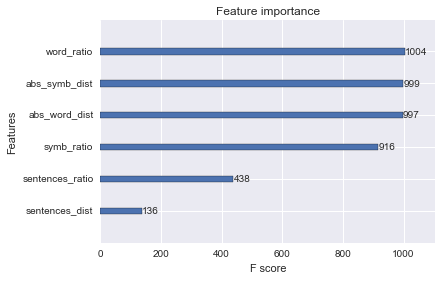

In [147]:
plot_importance(model)

In [34]:
X_test = extract_features(df_test, pd.DataFrame())

In [73]:
y_test = model.predict(xgb.DMatrix(X_test))

In [75]:
output(y_test, 'second_xgb.csv')

In [ ]:
Скор на кэгле - 0.51

# Буквенные n-grammы и бинарные меры сходства

In [54]:
cv_char = CountVectorizer(ngram_range=(1, 3), analyzer='char')
cv_char.fit_transform(df_train['question1'].tolist() + df_train['question2'].tolist())

<808580x47145 sparse matrix of type '<class 'numpy.int64'>'
	with 64444143 stored elements in Compressed Sparse Row format>

In [55]:
m_q1 = cv_char.transform(df_train['question1'].values)
m_q2 = cv_char.transform(df_train['question2'].values)

In [61]:
unigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 1])
ix_unigrams = np.sort(list(unigrams.values()))
bigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 2])
ix_bigrams = np.sort(list(bigrams.values()))
trigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 3])
ix_trigrams = np.sort(list(trigrams.values()))

Попробуем применить несколько бинарных мер сходства к сгенерированным буквенным n-граммам: <br>
1) Коэффициент Жаккара https://ru.wikipedia.org/wiki/Коэффициент_Жаккара

2) Коэффициент Серенсена https://ru.wikipedia.org/wiki/Коэффициент_Сёренсена

3) Коэффцициент Симпсона https://ru.wikipedia.org/wiki/Коэффициент_Симпсона

In [67]:
v_num = (m_q1[:, ix_unigrams]).minimum((m_q2[:, ix_unigrams])).sum(axis=1)
v_den = (m_q1[:, ix_unigrams] ).maximum((m_q2[:, ix_unigrams] )).sum(axis=1)
djaccar_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

In [63]:
v_num = 2 * (m_q1[:, ix_unigrams]).minimum((m_q2[:, ix_bigrams])).sum(axis=1)
v_den = ((m_q1[:, ix_unigrams]) + (m_q2[:, ix_unigrams])).sum(axis=1)
serensen_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

In [64]:
v_num = (m_q1[:, ix_unigrams]).minimum((m_q2[:, ix_unigrams])).sum(axis=1)
v_den = np.minimum((m_q1[:, ix_unigrams]).sum(axis=1), (m_q2[:, ix_unigrams]).sum(axis=1))
simpson_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

Добавим полученные меры к уже имеющимся признакам

In [163]:
X_train['simpson_score'] = simpson_score
X_train['serensen_score'] = serensen_score
X_train['djaccar_score'] = djaccar_score

In [149]:
X_train.head()

,abs_symb_dist,symb_ratio,abs_word_dist,word_ratio,sentences_dist,sentences_ratio,simpson_score,serensen_score,djaccar_score
0,6.0,0.853659,1.0,0.857143,0.0,1.0,1.000000,0.235294,1.000000
1,32.0,0.555556,5.0,0.615385,0.0,1.0,1.000000,0.320000,0.640000
2,7.0,0.820513,1.0,0.833333,0.0,1.0,0.857143,0.235294,0.705882
3,25.0,0.479167,5.0,0.444444,1.0,0.5,0.692308,0.080000,0.360000
4,28.0,0.508772,5.0,0.500000,0.0,1.0,0.937500,0.166667,0.625000


In [150]:
model = get_xgboost(X_train, y_train)

[0]	train-logloss:0.68928	valid-logloss:0.68928
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.65767	valid-logloss:0.65767
[20]	train-logloss:0.635521	valid-logloss:0.635521
[30]	train-logloss:0.619598	valid-logloss:0.619598
[40]	train-logloss:0.607718	valid-logloss:0.607718
[50]	train-logloss:0.598839	valid-logloss:0.598839
[60]	train-logloss:0.592169	valid-logloss:0.592169
[70]	train-logloss:0.587069	valid-logloss:0.587069
[80]	train-logloss:0.583129	valid-logloss:0.583129
[90]	train-logloss:0.580034	valid-logloss:0.580034
[100]	train-logloss:0.57763	valid-logloss:0.57763
[110]	train-logloss:0.575753	valid-logloss:0.575753
[120]	train-logloss:0.574157	valid-logloss:0.574157
[130]	train-logloss:0.572863	valid-logloss:0.572863
[140]	train-logloss:0.571843	valid-logloss:0.571843
[150]	train-logloss:0.57097	valid-logloss:0.57097
[160]	train-logloss:0.570237	valid-l

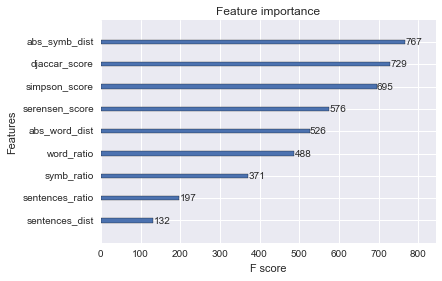

In [151]:
plot_importance(model)

In [33]:
def get_n_gramms(df):
    cv_char = CountVectorizer(ngram_range=(1, 3), analyzer='char')
    cv_char.fit_transform(df['question1'].tolist() + df['question2'].tolist())
    
    m_q1 = cv_char.transform(df['question1'].values)
    m_q2 = cv_char.transform(df['question2'].values)
    
    unigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 1])
    ix_unigrams = np.sort(list(unigrams.values()))
    bigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 2])
    ix_bigrams = np.sort(list(bigrams.values()))
    trigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 3])
    ix_trigrams = np.sort(list(trigrams.values()))
    
    return {
        'ix_unigrams': ix_unigrams,
        'ix_bigrams': ix_bigrams,
        'ix_trigrams': ix_trigrams,
        'm_q1': m_q1,
        'm_q2': m_q2,
    }

In [56]:
def binary_metrics(m_q1, m_q2, ngramms):
    v_num = (m_q1[:, ngramms]).minimum((m_q2[:, ngramms])).sum(axis=1)
    v_den = (m_q1[:, ngramms]).maximum((m_q2[:, ngramms])).sum(axis=1)
    djaccar_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]
    
    v_num = 2 * (m_q1[:, ngramms]).minimum((m_q2[:, ngramms])).sum(axis=1)
    v_den = ((m_q1[:, ngramms]) + (m_q2[:, ngramms])).sum(axis=1)
    serensen_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]
    
    v_num = (m_q1[:, ngramms]).minimum((m_q2[:, ngramms])).sum(axis=1)
    v_den = np.minimum((m_q1[:, ngramms] > 0).sum(axis=1), (m_q2[:, ngramms] > 0).sum(axis=1))
    simpson_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]
    
    return {
        'djaccar_score': djaccar_score,
        'serensen_score': serensen_score,
        'simpson_score': simpson_score
    }

In [98]:
test_ngramms = get_n_gramms(df_test)

In [ ]:
train_ngramms = get_n_gramms(df_train)

In [39]:
uni_metrics = binary_metrics(test_ngramms['m_q1'], test_ngramms['m_q2'], test_ngramms['ix_unigrams'])

In [170]:
X_test['simpson_score'] = uni_metrics['simpson_score']
X_test['serensen_score'] = uni_metrics['serensen_score']
X_test['djaccar_score'] = uni_metrics['djaccar_score']

In [55]:
X_test.head()

,abs_symb_dist,symb_ratio,abs_word_dist,word_ratio,sentences_dist,sentences_ratio,simpson_score,serensen_score,djaccar_score
0,21.0,0.580000,4.0,0.600000,0.0,1.0,0.928571,1.444444,0.722222
1,6.0,0.850000,2.0,0.714286,1.0,0.5,0.941176,1.454545,0.727273
2,12.0,0.586207,3.0,0.500000,0.0,1.0,1.000000,1.529412,0.764706
3,6.0,0.647059,0.0,1.000000,0.0,1.0,0.888889,1.230769,0.615385
4,14.0,0.500000,1.0,0.666667,0.0,1.0,1.000000,1.375000,0.687500


In [56]:
y_test = model.predict(xgb.DMatrix(X_test))

In [59]:
output(y_test, 'third_xgb.csv')

Скор на кэгле - 0.42
Попробуем теперь добавить бинарные меры на биграммах и триграммах

In [62]:
train_ngramms = get_n_gramms(df_train)

In [63]:
bi_metrics_train = binary_metrics(train_ngramms['m_q1'], train_ngramms['m_q2'], train_ngramms['ix_bigrams'])

In [64]:
tri_metrics_train = binary_metrics(train_ngramms['m_q1'], train_ngramms['m_q2'], train_ngramms['ix_trigrams'])

In [154]:
X_train['bi_simpson_score'] = bi_metrics_train['simpson_score']
X_train['bi_serensen_score'] = bi_metrics_train['serensen_score']
X_train['bi_djaccar_score'] = bi_metrics_train['djaccar_score']

In [167]:
X_train.head()

,abs_symb_dist,symb_ratio,abs_word_dist,word_ratio,sentences_dist,sentences_ratio,simpson_score,serensen_score,djaccar_score,bi_simpson_score,bi_serensen_score,bi_djaccar_score
0,6.0,0.853659,1.0,0.857143,0.0,1.0,1.000000,0.235294,1.000000,0.962963,1.677419,0.838710
1,32.0,0.555556,5.0,0.615385,0.0,1.0,1.000000,0.320000,0.640000,0.933333,0.965517,0.482759
2,7.0,0.820513,1.0,0.833333,0.0,1.0,0.857143,0.235294,0.705882,0.700000,0.954545,0.477273
3,25.0,0.479167,5.0,0.444444,1.0,0.5,0.692308,0.080000,0.360000,0.000000,0.000000,0.000000
4,28.0,0.508772,5.0,0.500000,0.0,1.0,0.937500,0.166667,0.625000,0.500000,0.419355,0.209677


In [155]:
model = get_xgboost(X_train, y_train)

[0]	train-logloss:0.687769	valid-logloss:0.687769
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.64396	valid-logloss:0.64396
[20]	train-logloss:0.613285	valid-logloss:0.613285
[30]	train-logloss:0.591101	valid-logloss:0.591101
[40]	train-logloss:0.574723	valid-logloss:0.574723
[50]	train-logloss:0.5625	valid-logloss:0.5625
[60]	train-logloss:0.553066	valid-logloss:0.553066
[70]	train-logloss:0.545869	valid-logloss:0.545869
[80]	train-logloss:0.540309	valid-logloss:0.540309
[90]	train-logloss:0.536013	valid-logloss:0.536013
[100]	train-logloss:0.532665	valid-logloss:0.532665
[110]	train-logloss:0.529984	valid-logloss:0.529984
[120]	train-logloss:0.52778	valid-logloss:0.52778
[130]	train-logloss:0.525983	valid-logloss:0.525983
[140]	train-logloss:0.52452	valid-logloss:0.52452
[150]	train-logloss:0.523311	valid-logloss:0.523311
[160]	train-logloss:0.522327	valid-log

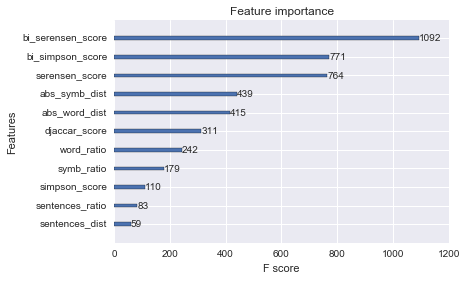

In [156]:
plot_importance(model)

In [171]:
X_test['bi_simpson_score'] = bi_metrics_test['simpson_score']
X_test['bi_serensen_score'] = bi_metrics_test['serensen_score']
X_test['bi_djaccar_score'] = bi_metrics_test['djaccar_score']

In [172]:
y_test = model.predict(xgb.DMatrix(X_test))
output(y_test, 'fourth_xgb.csv')

In [ ]:
Скор на кэгле - 0.43

In [173]:
X_train['tri_simpson_score'] = tri_metrics_train['simpson_score']
X_train['tri_serensen_score'] = tri_metrics_train['serensen_score']
X_train['tri_djaccar_score'] = tri_metrics_train['djaccar_score']

In [174]:
model = get_xgboost(X_train, y_train)

[0]	train-logloss:0.687618	valid-logloss:0.687618
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.642607	valid-logloss:0.642607
[20]	train-logloss:0.611043	valid-logloss:0.611043
[30]	train-logloss:0.588123	valid-logloss:0.588123
[40]	train-logloss:0.57118	valid-logloss:0.57118
[50]	train-logloss:0.558378	valid-logloss:0.558378
[60]	train-logloss:0.548583	valid-logloss:0.548583
[70]	train-logloss:0.541106	valid-logloss:0.541106
[80]	train-logloss:0.535311	valid-logloss:0.535311
[90]	train-logloss:0.530808	valid-logloss:0.530808
[100]	train-logloss:0.527206	valid-logloss:0.527206
[110]	train-logloss:0.524323	valid-logloss:0.524323
[120]	train-logloss:0.521991	valid-logloss:0.521991
[130]	train-logloss:0.520117	valid-logloss:0.520117
[140]	train-logloss:0.518543	valid-logloss:0.518543
[150]	train-logloss:0.517223	valid-logloss:0.517223
[160]	train-logloss:0.516222	v

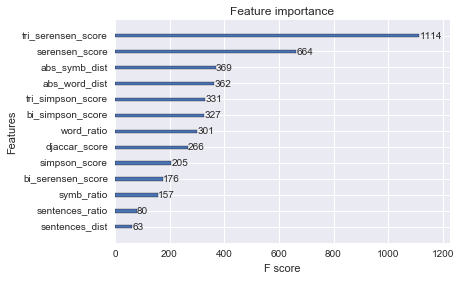

In [175]:
plot_importance(model)

In [70]:
X_test['tri_simpson_score'] = tri_metrics_test['simpson_score']
X_test['tri_serensen_score'] = tri_metrics_test['serensen_score']
X_test['tri_djaccar_score'] = tri_metrics_test['djaccar_score']

In [87]:
y_test = model.predict(xgb.DMatrix(X_test))

In [88]:
output(y_test, 'fourth_xgb.csv')

In [ ]:
Скор на кэгле - 0.44. Качество  модели на тесте ухудшилось, хотя на обучении видно, что качество значительно улучшилось. 
Вероятно, это связано с особенностью тестовой выборки, то что в ней присутствует большое количество синтетических данных.

In [75]:
X_test.to_csv('features_test1.csv', index=False)
X_train.to_csv('features_train1.csv', index=False)

In [8]:
X_test = pd.read_csv('features_test1.csv')
X_train  = pd.read_csv('features_train1.csv')

# Бинарные меры сходства на словесных n-grammax

In [4]:
def get_word_n_gramms(df):
    cv_word = CountVectorizer(ngram_range=(1, 3), analyzer='word')
    cv_word.fit(df['question1'].tolist() + df['question2'].tolist())
    
    m_q1 = cv_word.transform(df['question1'].values)
    m_q2 = cv_word.transform(df['question2'].values)
    
    unigrams = dict([(k, v) for (k, v) in cv_word.vocabulary_.items() if len(k) == 1])
    ix_unigrams = np.sort(list(unigrams.values()))
    bigrams = dict([(k, v) for (k, v) in cv_word.vocabulary_.items() if len(k) == 2])
    ix_bigrams = np.sort(list(bigrams.values()))
    trigrams = dict([(k, v) for (k, v) in cv_word.vocabulary_.items() if len(k) == 3])
    ix_trigrams = np.sort(list(trigrams.values()))
    
    return {
        'ix_unigrams': ix_unigrams,
        'ix_bigrams': ix_bigrams,
        'ix_trigrams': ix_trigrams,
        'm_q1': m_q1,
        'm_q2': m_q2,
    }

In [43]:
train_word_n_gramms = get_word_n_gramms(df_train)

In [31]:
test_word_n_gramms = get_word_n_gramms(df_test)

In [57]:
uni_word_metrics_train = binary_metrics(train_word_n_gramms['m_q1'], train_word_n_gramms['m_q2'], train_word_n_gramms['ix_unigrams'])
bi_word_metrics_train = binary_metrics(train_word_n_gramms['m_q1'], train_word_n_gramms['m_q2'], train_word_n_gramms['ix_bigrams'])
tri_word_metrics_train = binary_metrics(train_word_n_gramms['m_q1'], train_word_n_gramms['m_q2'], train_word_n_gramms['ix_trigrams'])

In [58]:
X_train['w_uni_simpson_score'] = uni_word_metrics_train['simpson_score']
X_train['w_uni_serensen_score'] = uni_word_metrics_train['serensen_score']
X_train['w_uni_djaccar_score'] = uni_word_metrics_train['djaccar_score']
X_train['w_bi_simpson_score'] = bi_word_metrics_train['simpson_score']
X_train['w_bi_serensen_score'] = bi_word_metrics_train['serensen_score']
X_train['w_bi_djaccar_score'] = bi_word_metrics_train['djaccar_score']
X_train['w_tri_simpson_score'] = tri_word_metrics_train['simpson_score']
X_train['w_tri_serensen_score'] = tri_word_metrics_train['serensen_score']
X_train['w_tri_djaccar_score'] = tri_word_metrics_train['djaccar_score']

In [37]:
model = get_xgboost(X_train, y_train)

[0]	train-logloss:0.687616	valid-logloss:0.687616
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.642582	valid-logloss:0.642582
[20]	train-logloss:0.610936	valid-logloss:0.610936
[30]	train-logloss:0.587988	valid-logloss:0.587988
[40]	train-logloss:0.570977	valid-logloss:0.570977
[50]	train-logloss:0.5581	valid-logloss:0.5581
[60]	train-logloss:0.548247	valid-logloss:0.548247
[70]	train-logloss:0.540667	valid-logloss:0.540667
[80]	train-logloss:0.534819	valid-logloss:0.534819
[90]	train-logloss:0.530281	valid-logloss:0.530281
[100]	train-logloss:0.526593	valid-logloss:0.526593
[110]	train-logloss:0.523662	valid-logloss:0.523662
[120]	train-logloss:0.521305	valid-logloss:0.521305
[130]	train-logloss:0.519364	valid-logloss:0.519364
[140]	train-logloss:0.517783	valid-logloss:0.517783
[150]	train-logloss:0.516407	valid-logloss:0.516407
[160]	train-logloss:0.515388	val

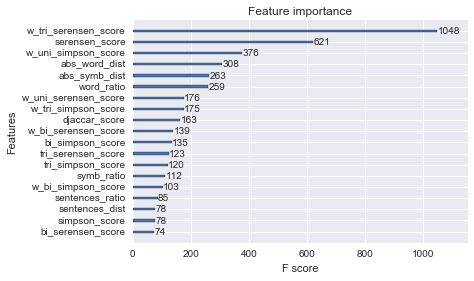

In [178]:
plot_importance(model)

In [38]:
uni_word_metrics_test = binary_metrics(test_word_n_gramms['m_q1'], test_word_n_gramms['m_q2'], test_word_n_gramms['ix_unigrams'])
bi_word_metrics_test = binary_metrics(test_word_n_gramms['m_q1'], test_word_n_gramms['m_q2'], test_word_n_gramms['ix_bigrams'])
tri_word_metrics_test = binary_metrics(test_word_n_gramms['m_q1'], test_word_n_gramms['m_q2'], test_word_n_gramms['ix_trigrams'])

In [39]:
X_test['w_uni_simpson_score'] = uni_word_metrics_test['simpson_score']
X_test['w_uni_serensen_score'] = uni_word_metrics_test['serensen_score']
X_test['w_uni_djaccar_score'] = uni_word_metrics_test['djaccar_score']
X_test['w_bi_simpson_score'] = bi_word_metrics_test['simpson_score']
X_test['w_bi_serensen_score'] = bi_word_metrics_test['serensen_score']
X_test['w_bi_djaccar_score'] = bi_word_metrics_test['djaccar_score']
X_test['w_tri_simpson_score'] = tri_word_metrics_test['simpson_score']
X_test['w_tri_serensen_score'] = tri_word_metrics_test['serensen_score']
X_test['w_tri_djaccar_score'] = tri_word_metrics_test['djaccar_score']

In [111]:
y_test = model.predict(xgb.DMatrix(X_test))

In [112]:
output(y_test, 'fifth_xgb.csv')

In [ ]:
Скор на кэгле - 0.41

In [113]:
X_test.to_csv('features_test2.csv', index=False)
X_train.to_csv('features_train2.csv', index=False)

In [71]:
X_test = pd.read_csv('features_test2.csv')
X_train = pd.read_csv('features_train2.csv')

# TF-IDF

In [7]:
def get_tfidf_n_gramms(m_q1, m_q2):
    tft = TfidfTransformer()

    tft = tft.fit(sparse.vstack((m_q1, m_q2)))
    tf_q1 = tft.transform(m_q1)
    tf_q2 = tft.transform(m_q2)
    
    return tf_q1, tf_q2

In [73]:
ix_bigrams = train_word_n_gramms['ix_bigrams']
ix_trigrams = train_word_n_gramms['ix_trigrams']
train_bi_q1 = train_word_n_gramms['m_q1'][:, ix_bigrams]
train_bi_q2 = train_word_n_gramms['m_q2'][:, ix_bigrams]
train_tri_q1 = train_word_n_gramms['m_q1'][:, ix_trigrams]
train_tri_q2 = train_word_n_gramms['m_q2'][:, ix_trigrams]

In [74]:
tf_bi_q1, tf_bi_q2 = get_tfidf_n_gramms(train_bi_q1, train_bi_q2)
tf_tri_q1, tf_tri_q2 = get_tfidf_n_gramms(train_tri_q1, train_tri_q2)

In [75]:
# Посчитаем эвклидово расстояние на триграммах и биграммах
eucl_bi = (tf_bi_q1 - tf_bi_q2)
eucl_bi = np.sqrt(np.array(eucl_bi.multiply(eucl_bi).sum(axis=1))[:, 0])
eucl_tri = (tf_tri_q1 - tf_tri_q2)
eucl_tri = np.sqrt(np.array(eucl_tri.multiply(eucl_tri).sum(axis=1))[:, 0])

In [76]:
X_train['eucl_bi'] = eucl_bi
X_train['eucl_tri'] = eucl_tri

In [77]:
model = get_xgboost(X_train, y_train)

[0]	train-logloss:0.687588	valid-logloss:0.687588
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.642159	valid-logloss:0.642159
[20]	train-logloss:0.610235	valid-logloss:0.610235
[30]	train-logloss:0.587112	valid-logloss:0.587112
[40]	train-logloss:0.569963	valid-logloss:0.569963
[50]	train-logloss:0.556489	valid-logloss:0.556489
[60]	train-logloss:0.54614	valid-logloss:0.54614
[70]	train-logloss:0.538253	valid-logloss:0.538253
[80]	train-logloss:0.532345	valid-logloss:0.532345
[90]	train-logloss:0.527717	valid-logloss:0.527717
[100]	train-logloss:0.524045	valid-logloss:0.524045
[110]	train-logloss:0.521105	valid-logloss:0.521105
[120]	train-logloss:0.518737	valid-logloss:0.518737
[130]	train-logloss:0.516794	valid-logloss:0.516794
[140]	train-logloss:0.51525	valid-logloss:0.51525
[150]	train-logloss:0.513952	valid-logloss:0.513952
[160]	train-logloss:0.512924	val

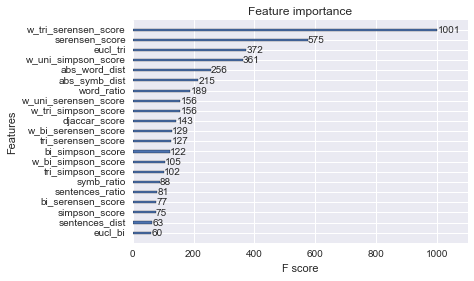

In [78]:
plot_importance(model)

In [79]:
ix_bigrams = test_word_n_gramms['ix_bigrams']
ix_trigrams = test_word_n_gramms['ix_trigrams']
test_bi_q1 = test_word_n_gramms['m_q1'][:, ix_bigrams]
test_bi_q2 = test_word_n_gramms['m_q2'][:, ix_bigrams]
test_tri_q1 = test_word_n_gramms['m_q1'][:, ix_trigrams]
test_tri_q2 = test_word_n_gramms['m_q2'][:, ix_trigrams]
tf_bi_q1, tf_bi_q2 = get_tfidf_n_gramms(test_bi_q1, test_bi_q2)
tf_tri_q1, tf_tri_q2 = get_tfidf_n_gramms(test_tri_q1, test_tri_q2)
eucl_bi = (tf_bi_q1 - tf_bi_q2)
eucl_bi = np.sqrt(np.array(eucl_bi.multiply(eucl_bi).sum(axis=1))[:, 0])
eucl_tri = (tf_tri_q1 - tf_tri_q2)
eucl_tri = np.sqrt(np.array(eucl_tri.multiply(eucl_tri).sum(axis=1))[:, 0])
X_test['eucl_bi'] = eucl_bi
X_test['eucl_tri'] = eucl_tri

In [80]:
y = model.predict(xgb.DMatrix(X_test))

In [81]:
output(y, 'sixth_xgb.csv')

Скор - 0.39

In [96]:
# Попробуем теперь другие модели

In [100]:
from sklearn.linear_model import LogisticRegression 

lr_model = LogisticRegression(penalty='l2',
                               tol=0.0001,
                               C=1.0,
                               fit_intercept=True,).fit(X_train, y_train)
y = lr_model.predict_proba(X_test)
output(y[:, 0], 'out.csv')

Скор - 0.65

In [102]:
from sklearn.ensemble import BaggingClassifier

bg_model = BaggingClassifier().fit(X_train, y_train)
y = bg_model.predict_proba(X_test)
output(y[:, 0], 'out.csv')

In [ ]:
Скор - 0.87

In [115]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier().fit(X_train, y_train)
y = ada.predict_proba(X_test)
output(y[:, 0], 'out.csv')

In [114]:
Скор - 0.71

In [116]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(loss='deviance',
                                        subsample=1.0,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_depth=3,
                                       ).fit(X_train, y_train)
y = gbc.predict_proba(X_test)
output(y[:, 0], 'out.csv')

In [ ]:
Скор - 0.69

In [122]:
from sklearn.linear_model import Ridge
rg = Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001).fit(X_train, y_train)
y = rg.predict(X_test)
output(y, 'out.csv')

Скор - 0.48

In [124]:
# Похоже, что xgboost - наилучший выбор. Попробуем подгнать для него параметры и произведем кросс-валидацию

In [127]:
from xgboost import XGBClassifier


In [140]:
XGBClassifier()

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [141]:
clf = XGBClassifier(
        nthread = 4,
        max_depth = 12,
        subsample = 0.5,
        colsample_bytree = 1.0,
        silent = 1,
        )
parameters = {
        'gamma': [0.05, 0.1, 0.3],
        'max_depth': [4, 6, 9],
        'subsample': [0.9, 1.0],
        'colsample_bytree': [0.9, 1.0],
    }
clf = GridSearchCV(clf, parameters, n_jobs=1, cv=2)
clf.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1.0,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=100, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=0.5),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'colsample_bytree': [0.9, 1.0], 'max_depth': [4, 6, 9], 'subsample': [0.9, 1.0], 'gamma': [0.05, 0.1, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [153]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4
params['n_estimators'] = 100
params['max_depth'] = 12
params['collsample_bytree'] = 1.0
params['colsample_bytree'] = 1.0
d_train = xgb.DMatrix(X_train, label=y_train)
model = xgb.train(params, d_train)

In [154]:
y_test = model.predict(xgb.DMatrix(X_test))

In [155]:
output(y_test, 'out.csv')